# Progetto Streaming Data Management & Time Series Analysis
## Parte di Machine Learning
### Studente: Federico De Servi
### Matricola: 812166



# Sommario

* [Importazione librerie](#librerie)
* [Data preprocessing](#preprocessing)
* [Approccio utilizzato](#approccio)
* [Modelli](#modelli)
    - [LSTM](#lstm1)
    - [LSTM Bidirezionale](#lstm2)
    - [CNN](#cnn)
* [Risultati](#risultati)
* [Conclusioni](#conclusioni)


<a name="librerie"></a>
# Librerie

Per prima cosa importiamo le librerie necessarie.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy import stats
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import os
import pathlib


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)


RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
rcParams['figure.figsize'] = 16, 10


<a name="preprocessing"></a>
# Data Preprocessing

Il Dataset che viene qui utilizzato è quello risultante dal preprocessing applicato nella parte ARIMA/UCM nel file R. Dopo aver effettuato alcuni step base come l'impostare il corretto formato per la data, definiamo le caratteristiche dello scaler usando i dati con cui abbiamo inizialmente scalato i dati nel file R. Lo scaler verrà utilizzato successivamente per plot e altro.

In [3]:
df = pd.read_csv("TrainingSetCleanNorm.csv")
df["DATA"] = pd.to_datetime(df['DATA']) + df['Ora'].astype('timedelta64[h]')
df['DATA'] = pd.to_datetime(df['DATA'])
df.set_index('DATA', inplace=True, drop=True)
df.drop(columns=["Unnamed: 0", "Ora", "VALORE"], inplace=True)

sc = StandardScaler()
sc.scale_ = 1258425
sc.var_ = 1583635000000
sc.mean_ = 4234049

Definiamo ora il valore "time steps". Esso definisce quante osservazioni nel futuro vogliamo predire e su quante osservazioni passate vogliamo basare la nostra predizione. 
Dopodichè definiamo il test size (pari agli ultimi 4 mesi) e il train size.

In [4]:
time_steps = 61*24

test_size = time_steps*2 
train_size = 1-test_size

train, test = df.iloc[0:train_size-1], df.iloc[train_size-1:len(df)]
print(len(train), len(test))

14616 2928


Il progetto ci richiede di calcolare le predizioni due mesi nel futuro, prendendo come input gli ultimi due mesi della serie temporale fornita. Per allenare e valutare i modelli, tuttavia, suddividiamo i dati nel seguente modo. Vediamo un plot della serie storica e della suddivisione in train e test sets.

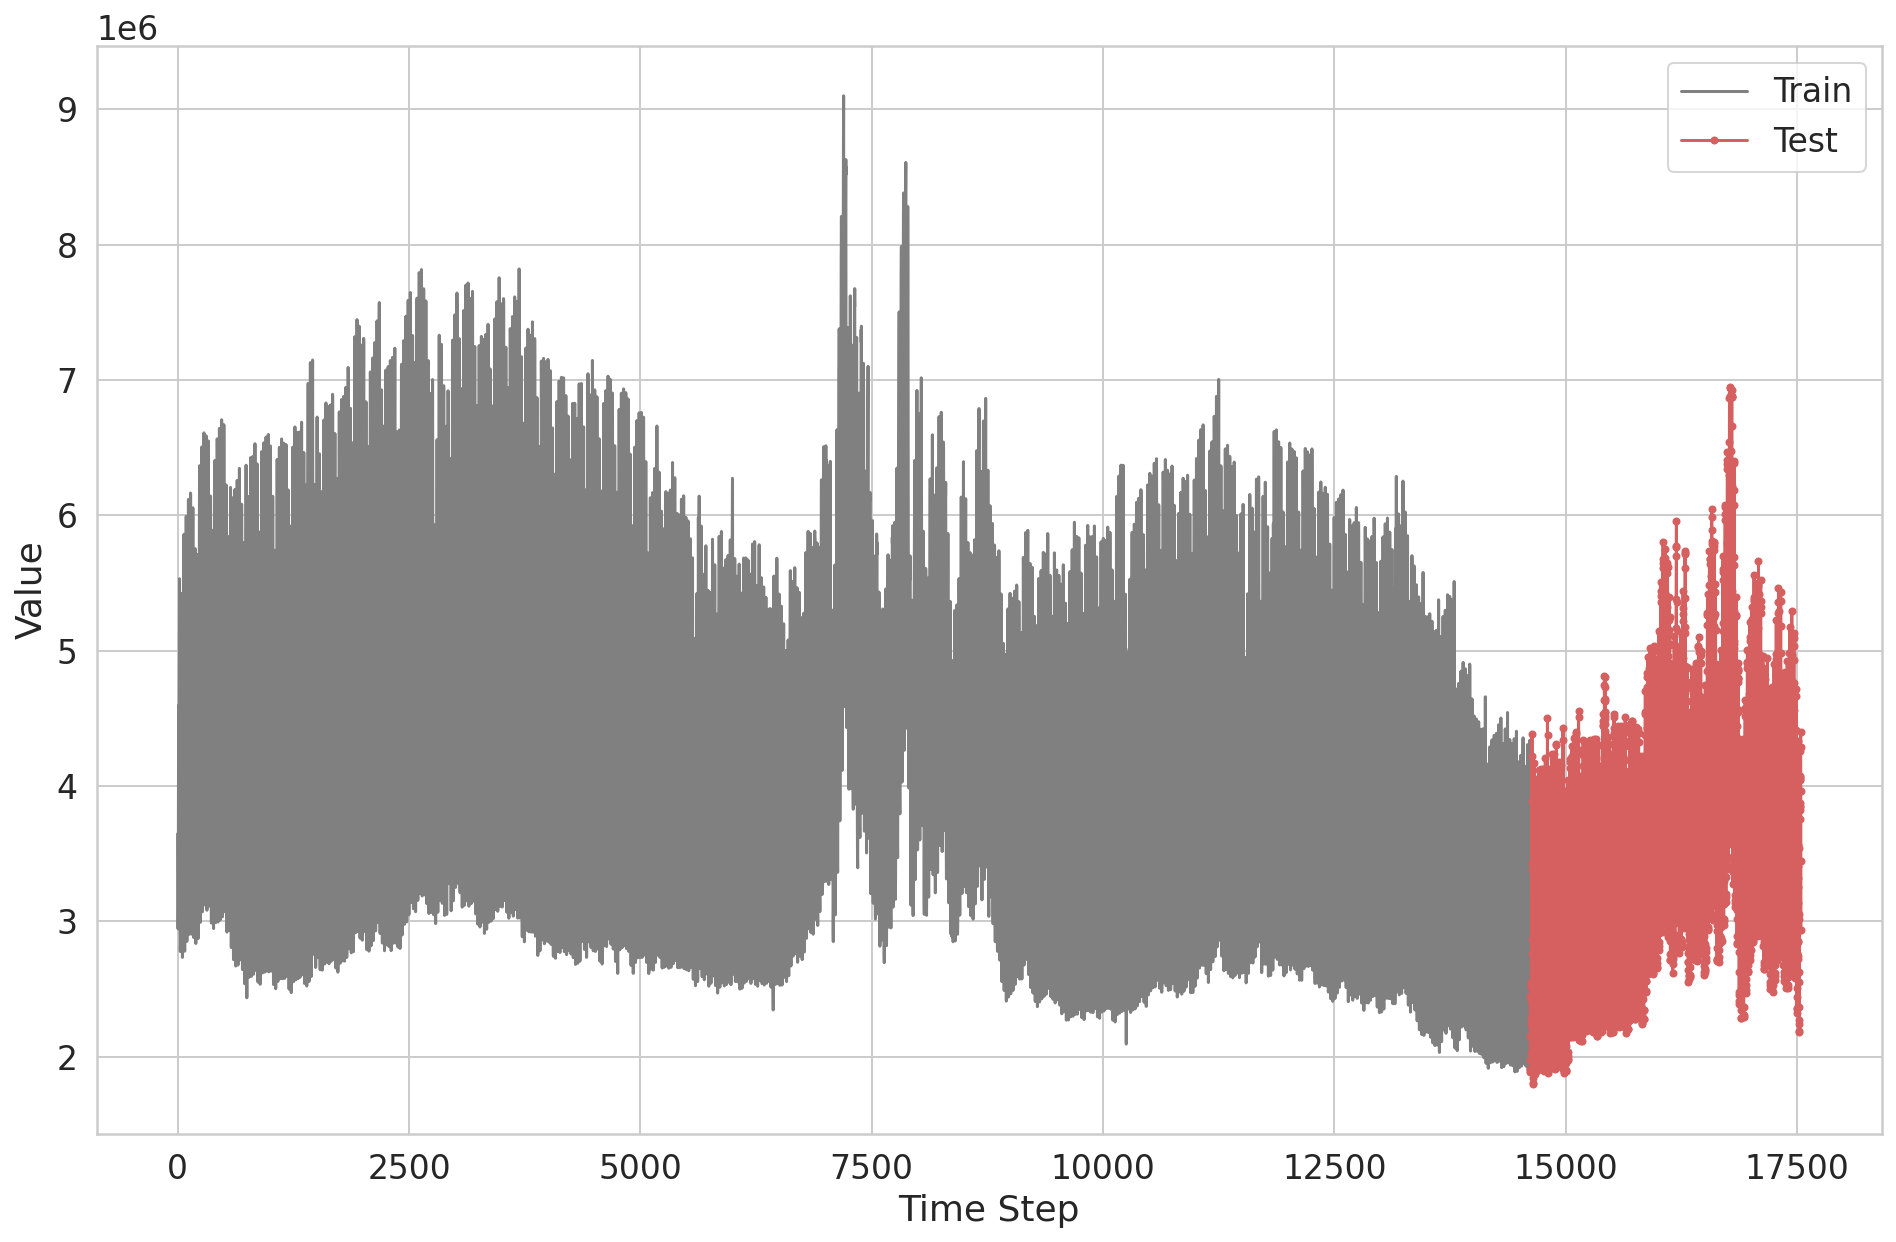

In [5]:
plt.plot(np.arange(0, len(train)), sc.inverse_transform(df.VALORE_NORM[:len(train)]), 'gray', label="Train")
plt.plot(np.arange(len(train), len(train)+ len(test)), sc.inverse_transform(df.VALORE_NORM[len(train):len(train)+len(test)]), 'r', marker='.', label="Test")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

Con la seguente funzione andiamo a creare le nostre X e le nostre Y. Ciò che effettua non è altro che creare i due array X e Y, dato un dataset, applicando un lag pari al valore di time_steps definito precedentemente. Notiamo come, in questo caso, si sia scelto di tenere look_back (numero di osservazioni passate su cui basare la nostra previsione) e time_steps (numero di osservazioni future da predire) uguali tra loro.

In [6]:
def processData(data, look_back, time_steps):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -time_steps +1):
        X.append(data[i:(i+look_back)].values)
        Y.append(data[(i+look_back):(i+look_back+time_steps)].values)
    return np.array(X),np.array(Y)

In [7]:
X_train, y_train = processData(train.VALORE_NORM,time_steps, time_steps)
X_test, y_test = processData(test.VALORE_NORM,time_steps, time_steps)

print(X_train.shape, y_train.shape)

(11689, 1464) (11689, 1464)


Infine espandiamo le dimensioni degli array X. Si tratta di un passo richiesto dalla natura dei modelli successivi e dalla shape dei dati che prendono in input.

In [8]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

<a name="approccio"></a>
# Approccio utilizzato

I modelli per time-series forecasting possono appartenere a due categorie di modelli che sfruttano approcci diversi alla soluzione del problema di forecasting: "Multi-step Autoregressive models" oppure "Multi-step single-shot models".

I modelli appartenenti alla prima categoria predicono un solo timestep per volta, e basando le previsioni successive (pari ai timestep futuri da prevedere richiesti dal problema) anche sulle proprie predizioni.
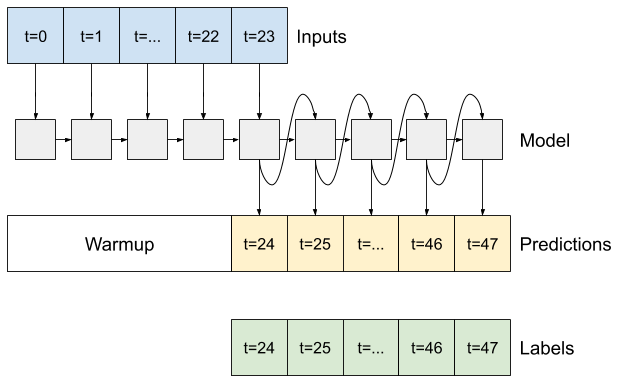

I modelli che invece vengono riportati in questo notebook sono stati provati usano l'approccio "Multi-step single-shot", ovvero predicono, dati n timesteps precedenti, gli n timesteps futuri in un unico momento (da lì la denominazione "single-shot"). 

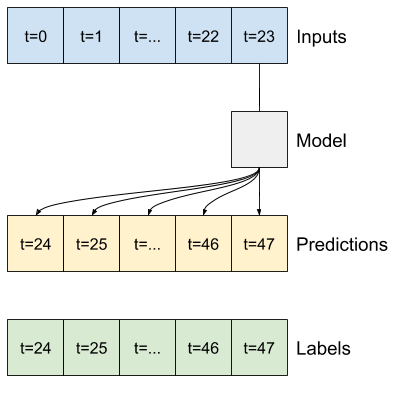

Questo perchè, dopo aver provato ad utilizzare modelli "Multi-step autoregressive" si è notato che essi producevano previsioni ben peggiori rispetto ai modelli single-shot e presentavano un MAE ben più basso. Si è quindi preferito riportare soltanto i modelli provati appartenenti a quest'ultima categoria.

<a name="modelli"></a>
# Modelli

Definiamo ora i tre modelli che sono stati provati.

Il primo è un classico modello LSTM sequenziale, composto da due layer LSTM con unità decrescenti, suddivisi da due layer di dropout. Il tutto seguito da un layer denso, ad attivazione lineare, con numero di unità pari al numero di osservazioni da predire (time_steps).

In [9]:
model_lstm1 = Sequential(
    [
        layers.LSTM(100,  return_sequences=True), 
        layers.Dropout(0.2),
        layers.LSTM(50), 
        layers.Dropout(0.2),
        layers.Dense(time_steps, activation='linear')
    ]
)

Il secondo è molto simile al modello precedente. L'unica differenza riguarda il fatto che i layer LSTM sono inclusi all'interno di un layer bidirezionale. Il modello così creato è un modello LSTM bidirezionale. 

In [10]:
model_lstm2 = Sequential(
    [
            layers.Bidirectional(LSTM(units = 100, return_sequences=True)),
            layers.Dropout(0.2),
            layers.Bidirectional(LSTM(units = 50)),
            layers.Dropout(0.2),
            layers.Dense(time_steps, activation='linear')
    ])

Infine l'ultimo modello provato è un modello CNN adattato per il forecasting di serie temporali. E' composto da un layer Convoluzionale 1D con 64 filtri da 3 e attivazione relu, segue poi un MaxPooling layer con pool size pari a 3, un layer flatten e un layer denso. Il tutto viene seguito da un layer di Dropout e l'ultimo layer Denso per la previsione delle n=time_steps osservazioni.

In [11]:
model_cnn = Sequential(
    [
            layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
            layers.MaxPooling1D(pool_size=3),
            layers.Flatten(),
            layers.Dense(50, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(time_steps, activation='linear')
    ])

<a name="lstm"></a>
## Training LSTM

Compiliamo il modello con loss=MAE e Adam come optimizer. Successivamente fittiamo il modello con 50 epoche, su una batch size pari a 100 e un validation split pari al 20%.

In [12]:
model_lstm1.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam(0.001))

In [13]:
history_lstm1 = model_lstm1.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=100, 
    validation_split=0.2, 
    verbose=1, 
    shuffle=False
)

Epoch 1/50
94/94 [==============================] - 23s 143ms/step - loss: 0.9028 - val_loss: 0.5662
Epoch 2/50
94/94 [==============================] - 13s 134ms/step - loss: 0.6268 - val_loss: 0.4344
Epoch 3/50
94/94 [==============================] - 13s 135ms/step - loss: 0.5520 - val_loss: 0.4414
Epoch 4/50
94/94 [==============================] - 13s 137ms/step - loss: 0.5378 - val_loss: 0.4368
Epoch 5/50
94/94 [==============================] - 13s 138ms/step - loss: 0.5295 - val_loss: 0.4288
Epoch 6/50
94/94 [==============================] - 13s 138ms/step - loss: 0.5481 - val_loss: 0.4372
Epoch 7/50
94/94 [==============================] - 13s 141ms/step - loss: 0.5193 - val_loss: 0.4285
Epoch 8/50
94/94 [==============================] - 13s 142ms/step - loss: 0.5220 - val_loss: 0.4258
Epoch 9/50
94/94 [==============================] - 13s 141ms/step - loss: 0.5197 - val_loss: 0.4247
Epoch 10/50
94/94 [==============================] - 13s 141ms/step - loss: 0.5108 - val_lo

Plottiamo qui la loss su training e validation dataset.

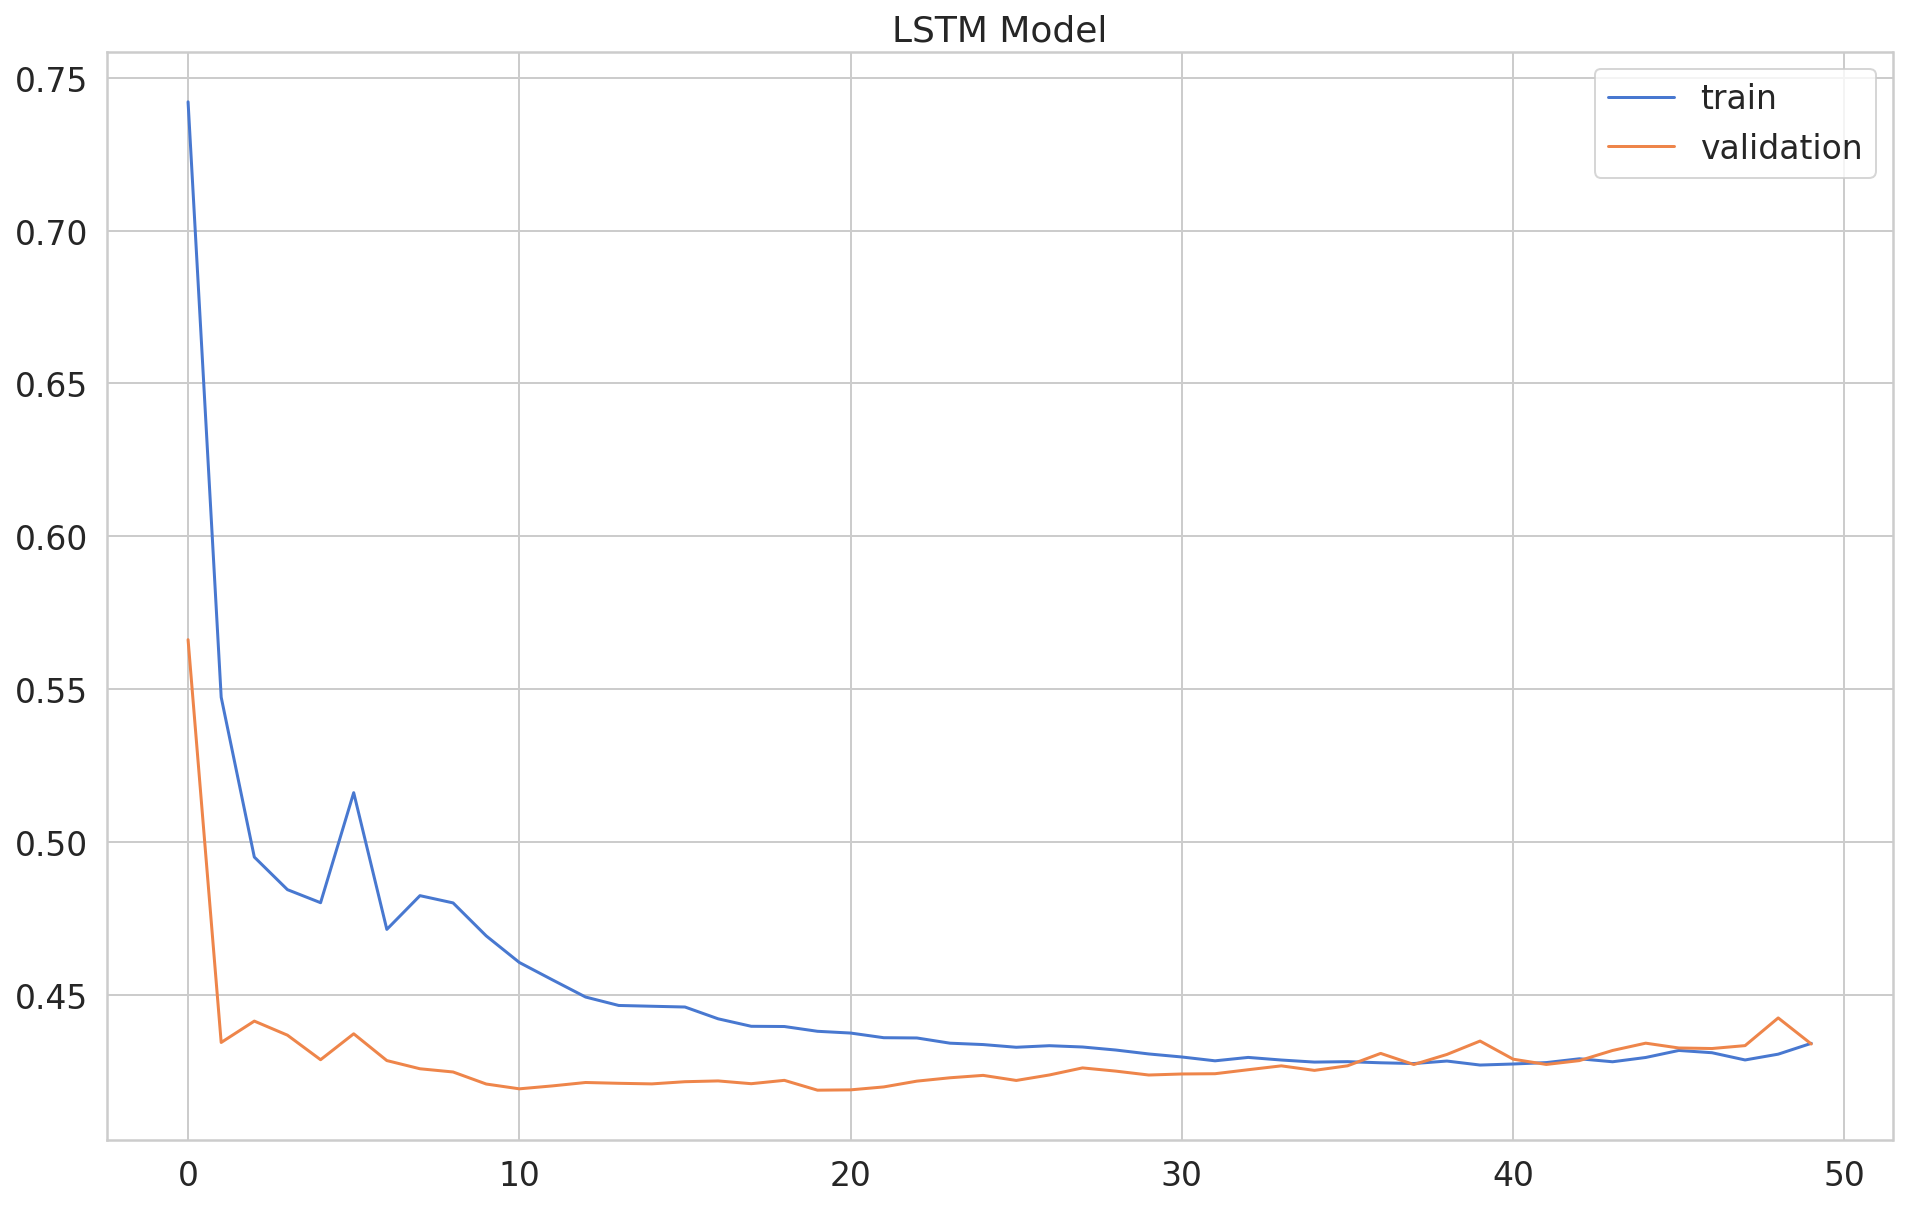

In [14]:
plt.plot(history_lstm1.history['loss'], label='train')
plt.plot(history_lstm1.history['val_loss'], label='validation')
plt.title("LSTM Model")
plt.savefig("lstm1_history.png")
plt.legend()

Ora effettuiamo le previsioni su X_test. Calcoliamo poi il mae sulle predizioni, trasformandolo con lo scaler che abbiamo definito ad inizio progetto, in modo da ottenere valori reali e non standardizzati.

In [15]:
y_pred_lstm1 = model_lstm1.predict(X_test) 

In [16]:
y_test_true = sc.inverse_transform(y_test)

In [17]:
y_pred_lstm1 = sc.inverse_transform(y_pred_lstm1)

mae_test_lstm1 = np.mean(abs(y_pred_lstm1 - y_test_true))
print(mae_test_lstm1)

595673.9643795355


Plottiamo quindi le previsioni. Nel primo grafico vediamo soltanto predizioni e valori reali di test, mentre nel secondo vediamo predizioni e valori reali del test nel contesto della serie storica nella sua completezza.

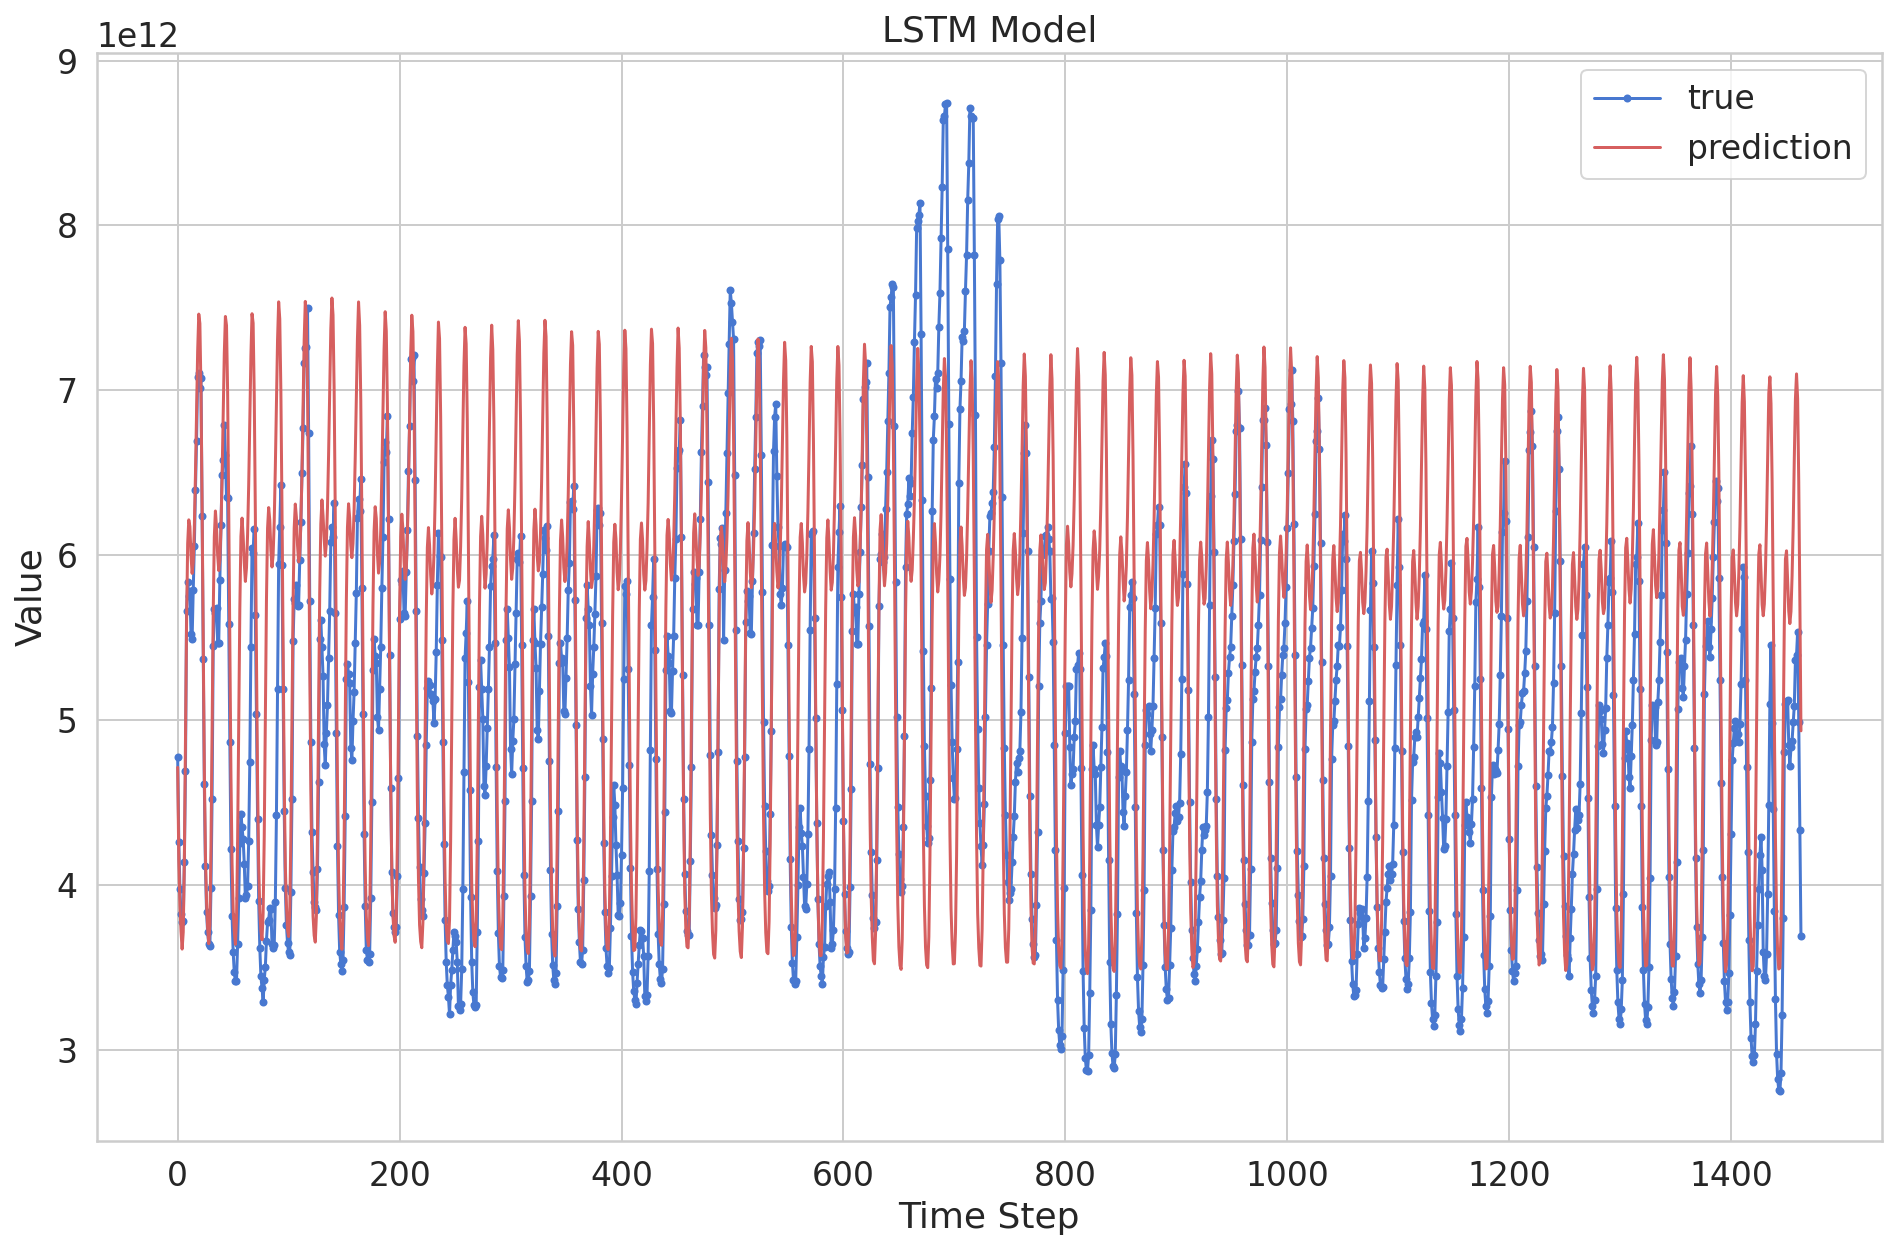

In [18]:
plt.plot(sc.inverse_transform(y_test_true[-1]), marker='.', label="true")
plt.plot(sc.inverse_transform(y_pred_lstm1.reshape(-1,1)), 'r', label="prediction")
plt.title("LSTM Model")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.savefig("lstm1_pred1.png")

plt.show()

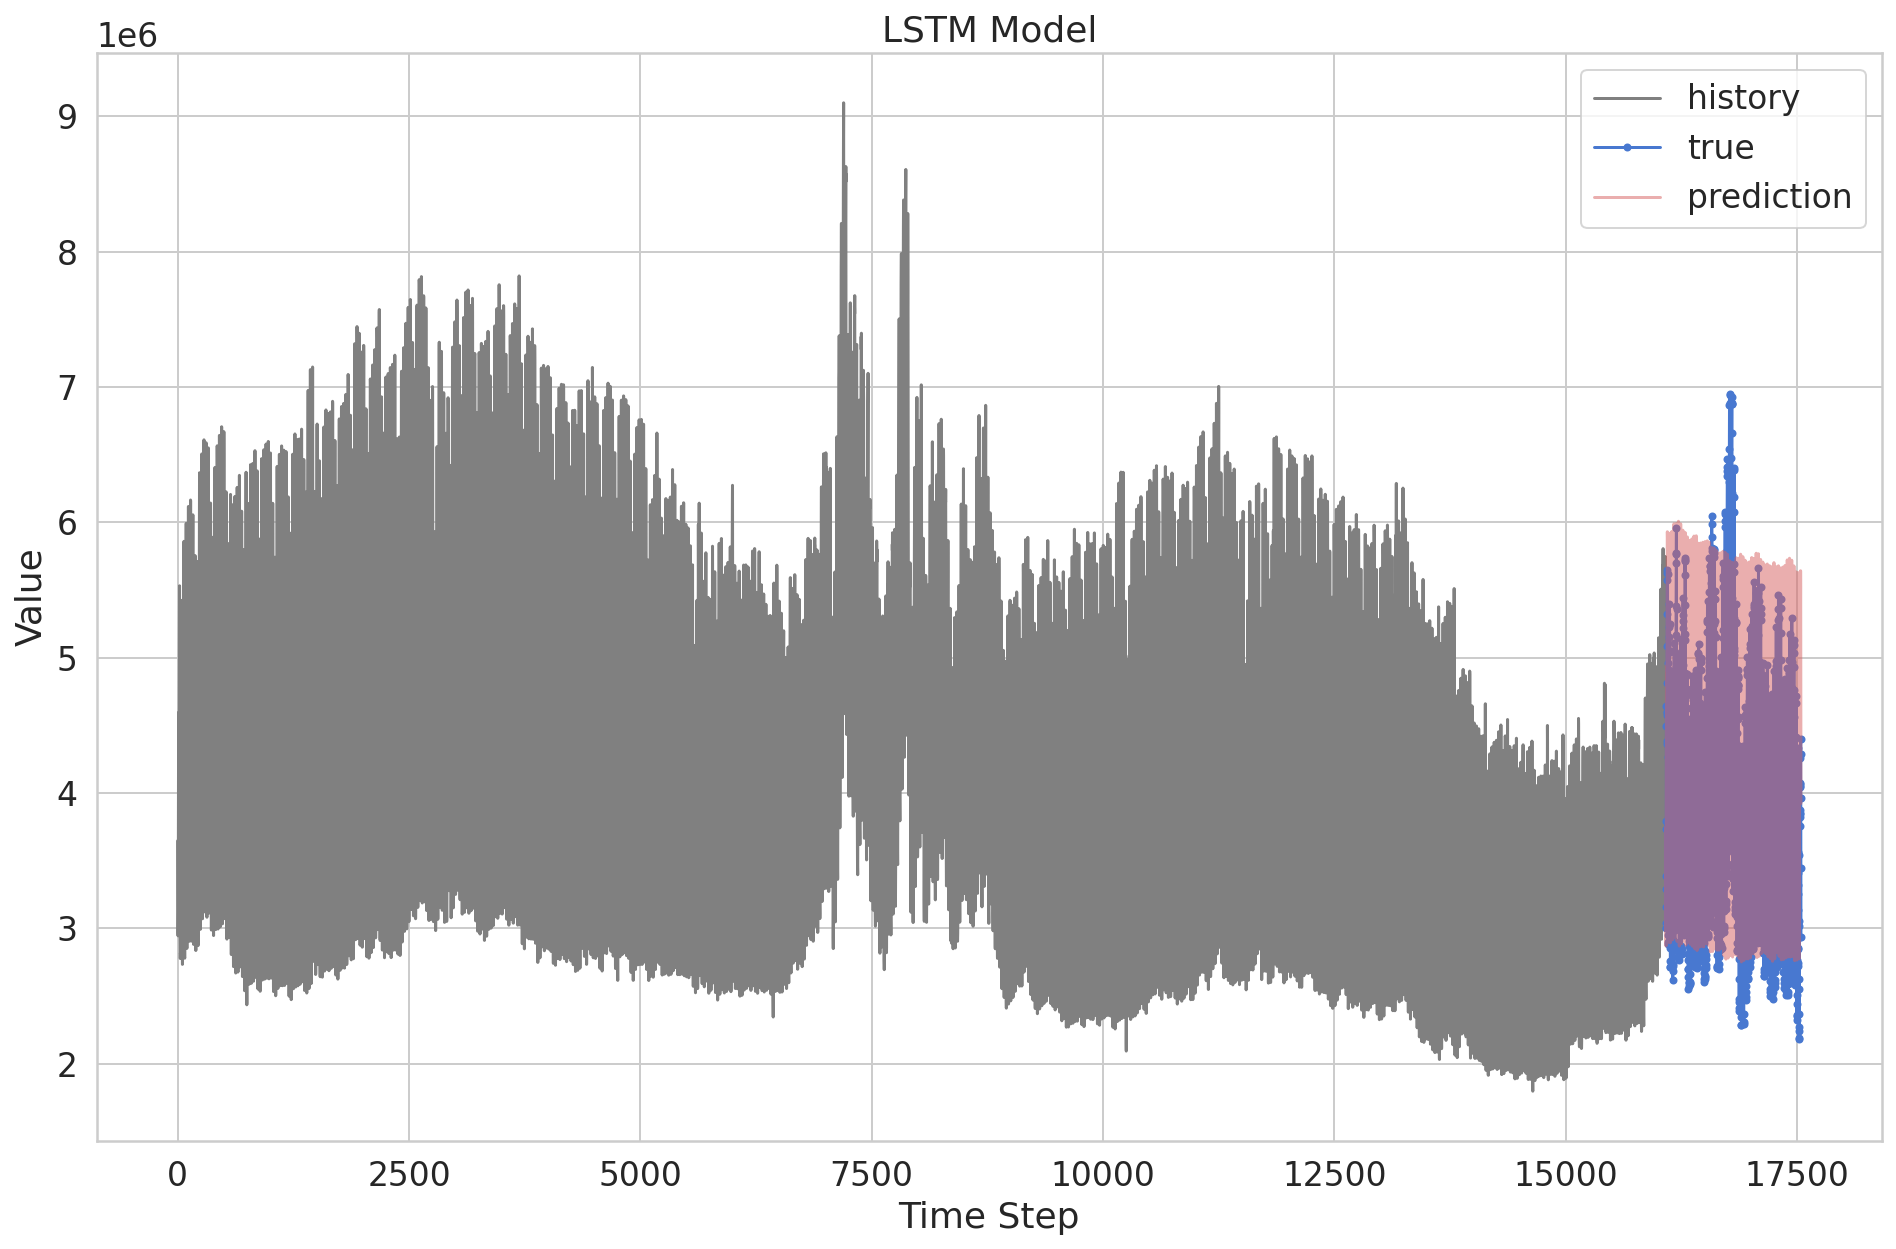

In [19]:
plt.plot(np.arange(0, len(train)+time_steps), sc.inverse_transform(df.VALORE_NORM[:len(train)+time_steps]), 'gray', label="history")
plt.plot(np.arange(len(train)+time_steps, len(train)+time_steps + len(y_test[-1])), y_test_true.reshape(-1,1), marker='.', label="true")
plt.plot(np.arange(len(train)+time_steps, len(train)+time_steps + len(y_test[-1])), y_pred_lstm1.reshape(-1,1), 'r', alpha=0.5, label="prediction")
plt.title("LSTM Model")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.savefig("lstm1_pred2.png")

plt.show()

<a name="lstm2"></a>
## Training Bidirectional LSTM 

Compiliamo il modello con loss=MAE e Adam come optimizer. Successivamente fittiamo il modello con 50 epoche e su una batch size pari a 100 e un validation split pari al 20%.

In [20]:
model_lstm2.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam(0.001))

In [21]:
history_lstm2 = model_lstm2.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=100, 
    validation_split=0.2, 
    verbose=1, 
    shuffle=False
)

Epoch 1/50
94/94 [==============================] - 36s 326ms/step - loss: 0.8535 - val_loss: 0.4780
Epoch 2/50
94/94 [==============================] - 29s 313ms/step - loss: 0.5756 - val_loss: 0.4278
Epoch 3/50
94/94 [==============================] - 29s 312ms/step - loss: 0.5731 - val_loss: 0.4419
Epoch 4/50
94/94 [==============================] - 29s 313ms/step - loss: 0.5331 - val_loss: 0.4354
Epoch 5/50
94/94 [==============================] - 29s 313ms/step - loss: 0.5177 - val_loss: 0.4296
Epoch 6/50
94/94 [==============================] - 29s 312ms/step - loss: 0.5190 - val_loss: 0.4298
Epoch 7/50
94/94 [==============================] - 29s 312ms/step - loss: 0.5074 - val_loss: 0.4292
Epoch 8/50
94/94 [==============================] - 29s 312ms/step - loss: 0.4910 - val_loss: 0.4353
Epoch 9/50
94/94 [==============================] - 29s 312ms/step - loss: 0.4884 - val_loss: 0.4295
Epoch 10/50
94/94 [==============================] - 29s 313ms/step - loss: 0.4862 - val_lo

Plottiamo qui la loss su training e validation dataset.




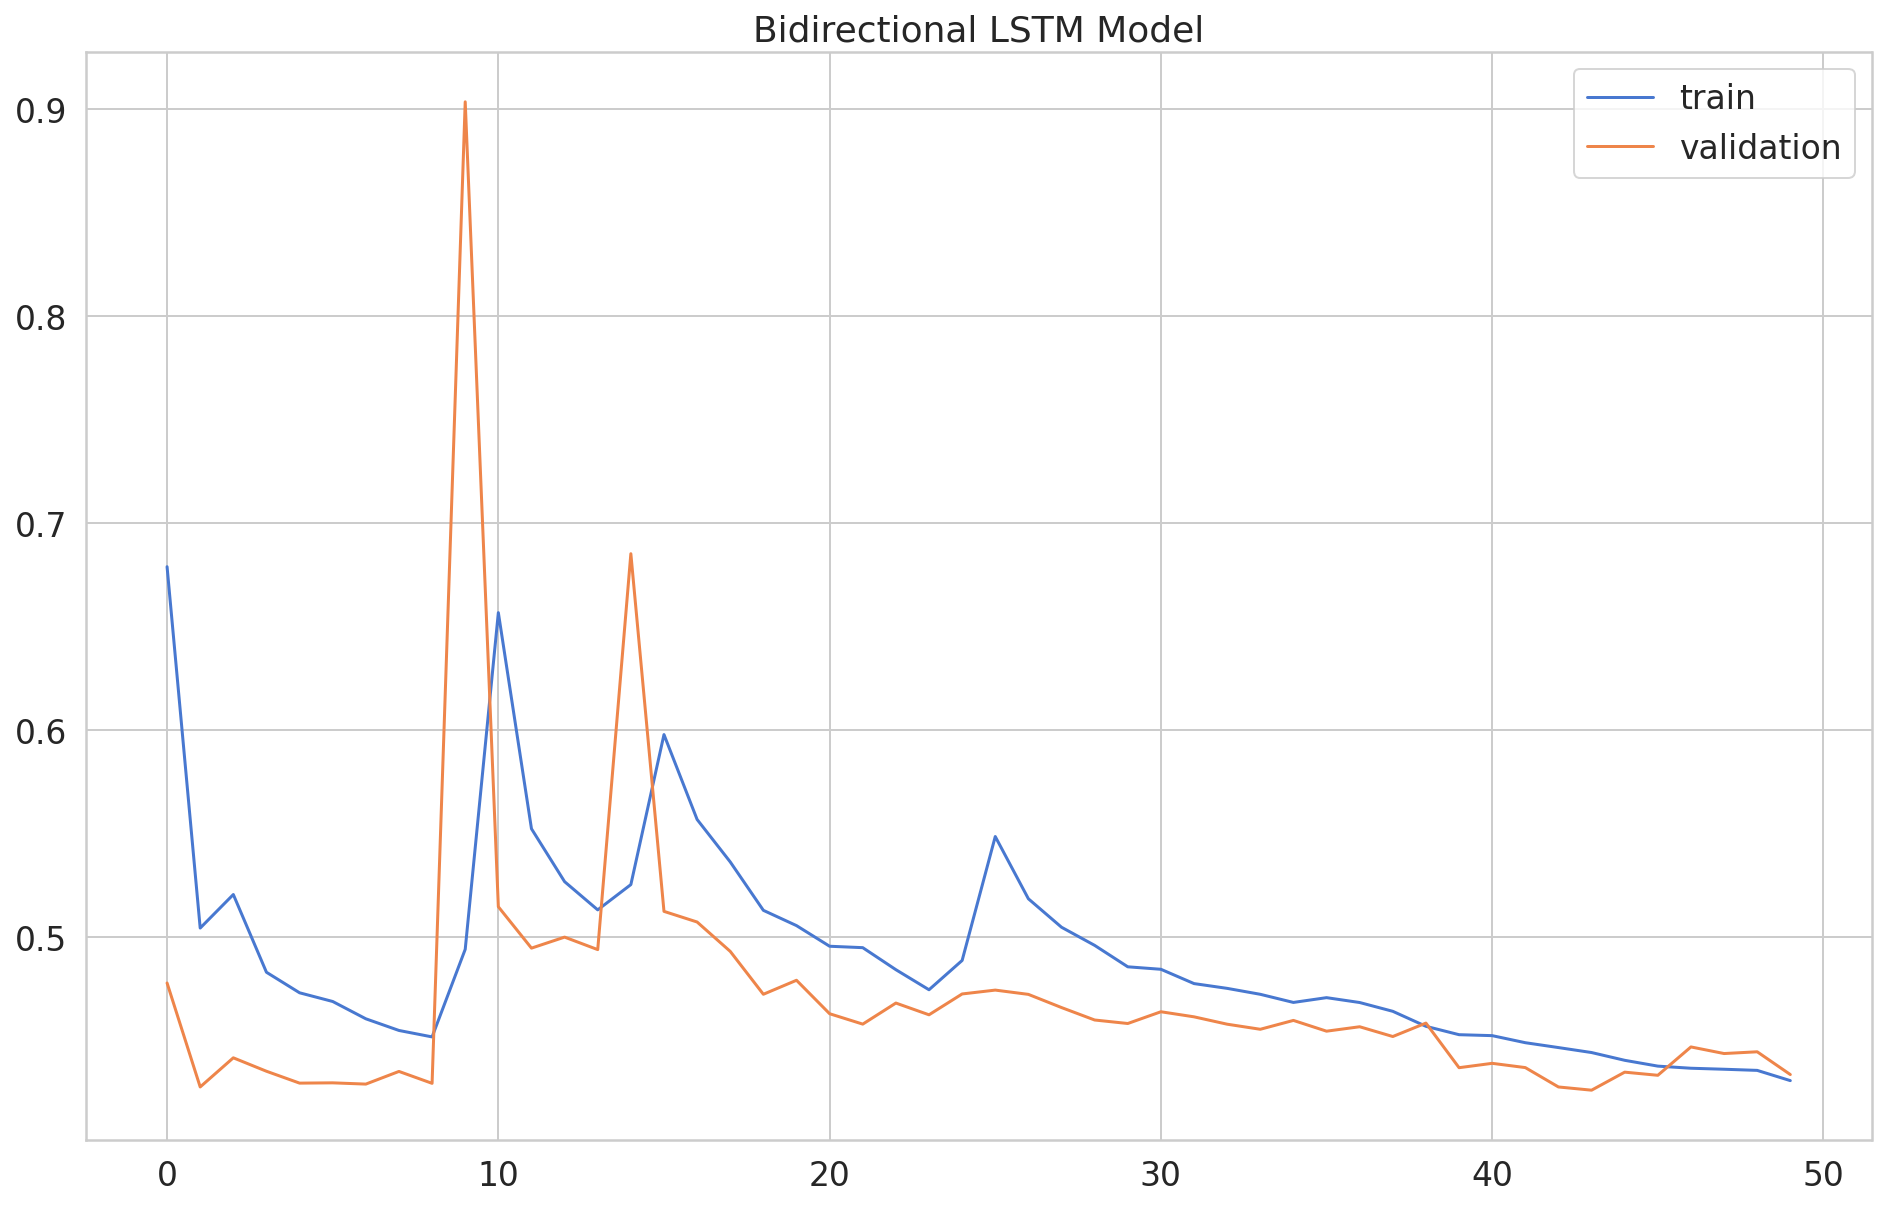

In [22]:
plt.plot(history_lstm2.history['loss'], label='train')
plt.plot(history_lstm2.history['val_loss'], label='validation')
plt.title("Bidirectional LSTM Model")
plt.savefig("lstm2_history.png")

plt.legend();

Ora effettuiamo le previsioni su X_test. Calcoliamo poi il mae sulle predizioni, trasformandolo con lo scaler che abbiamo definito ad inizio progetto, in modo da ottenere valori reali e non standardizzati.

In [23]:
y_pred_lstm2 = model_lstm2.predict(X_test)

In [24]:
y_pred_lstm2 = sc.inverse_transform(y_pred_lstm2)

mae_test_lstm2 = np.mean(abs(y_pred_lstm2 - y_test_true))
print(mae_test_lstm2)


775764.9585236936


Plottiamo quindi le previsioni. Nel primo grafico vediamo soltanto predizioni e valori reali di test, mentre nel secondo vediamo predizioni e valori reali del test nel contesto della serie storica nella sua completezza.

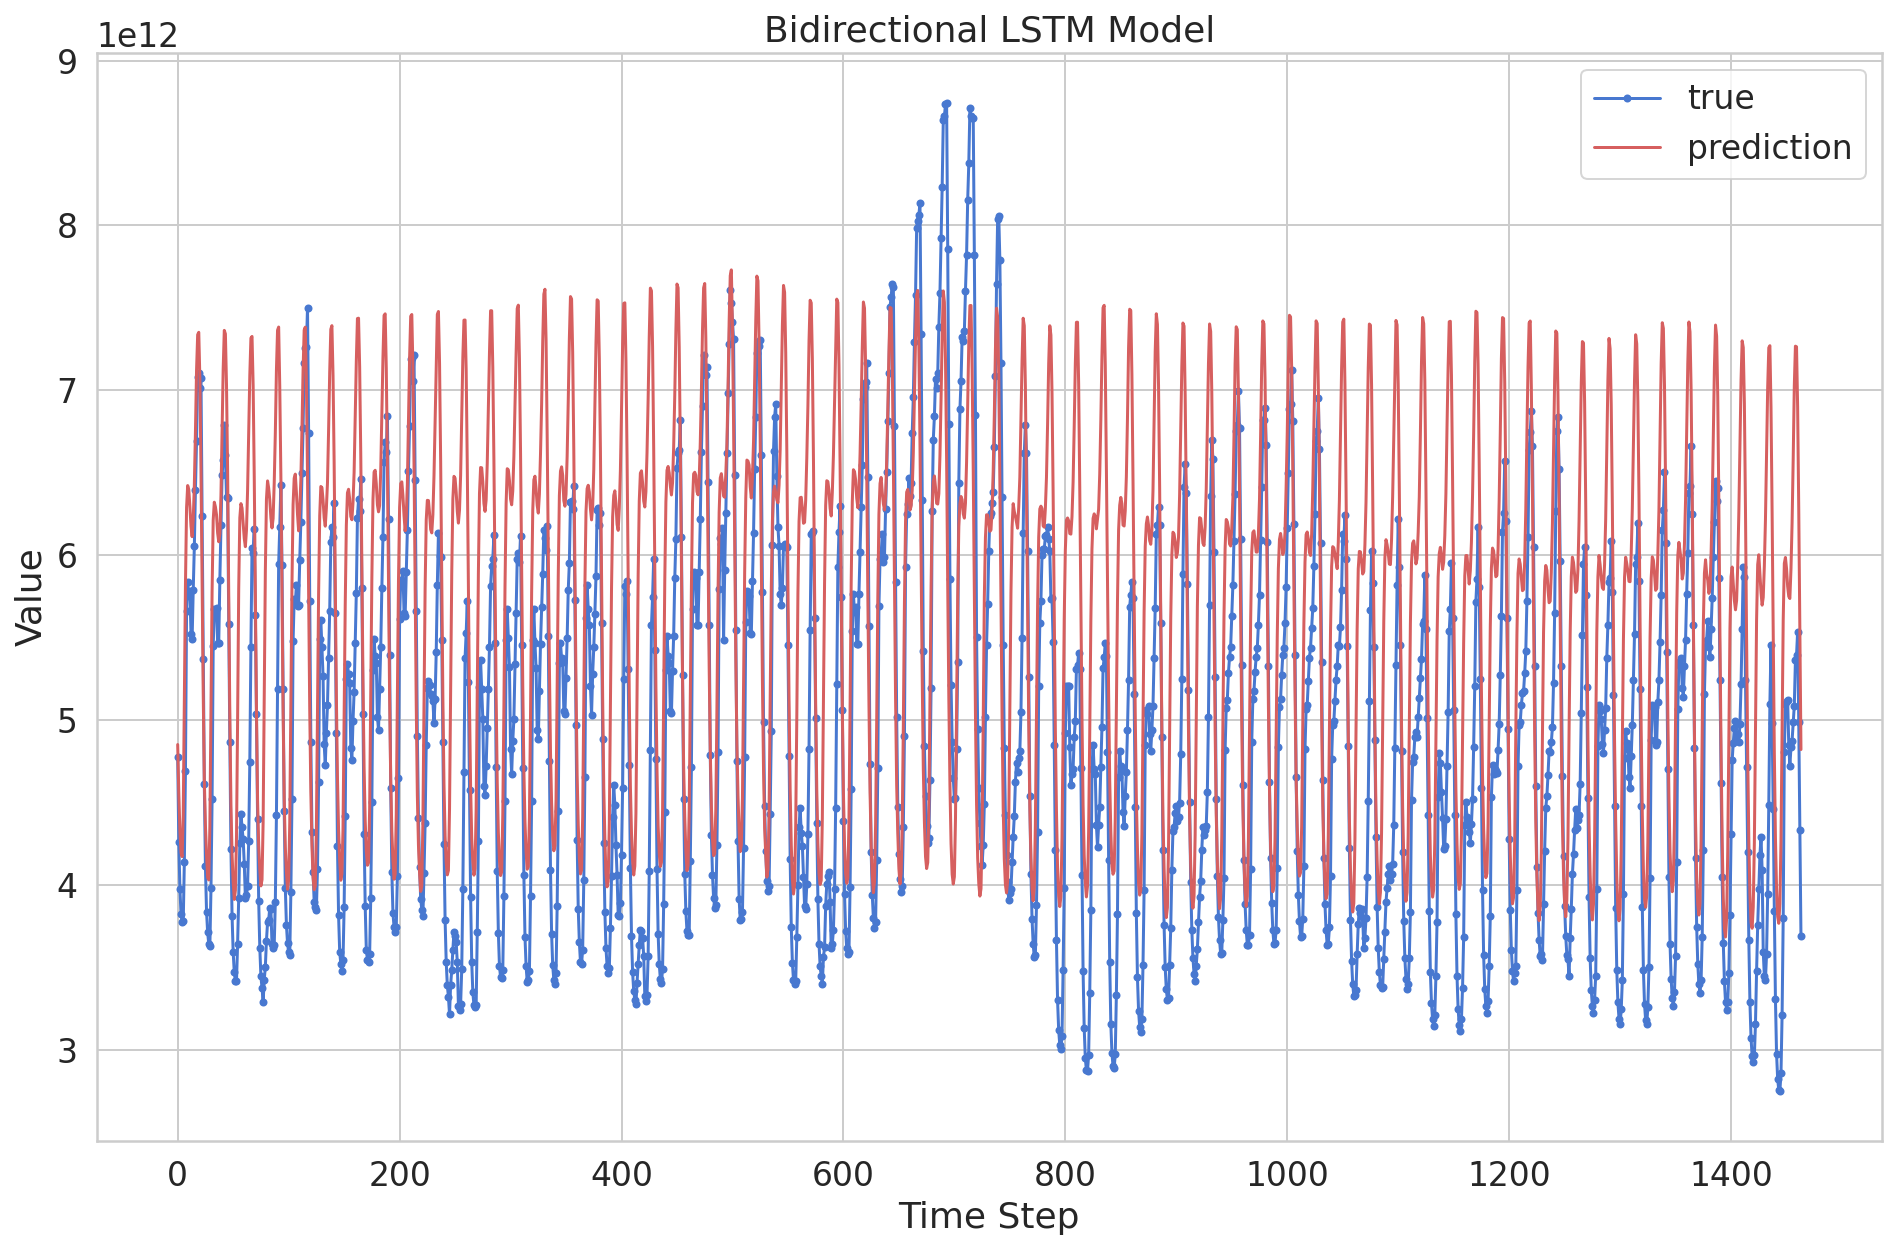

In [25]:
plt.plot(sc.inverse_transform(y_test_true[-1]), marker='.', label="true")
plt.plot(sc.inverse_transform(y_pred_lstm2.reshape(-1,1)), 'r', label="prediction")
plt.title("Bidirectional LSTM Model")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.savefig("lstm2_pred1.png")

plt.show()

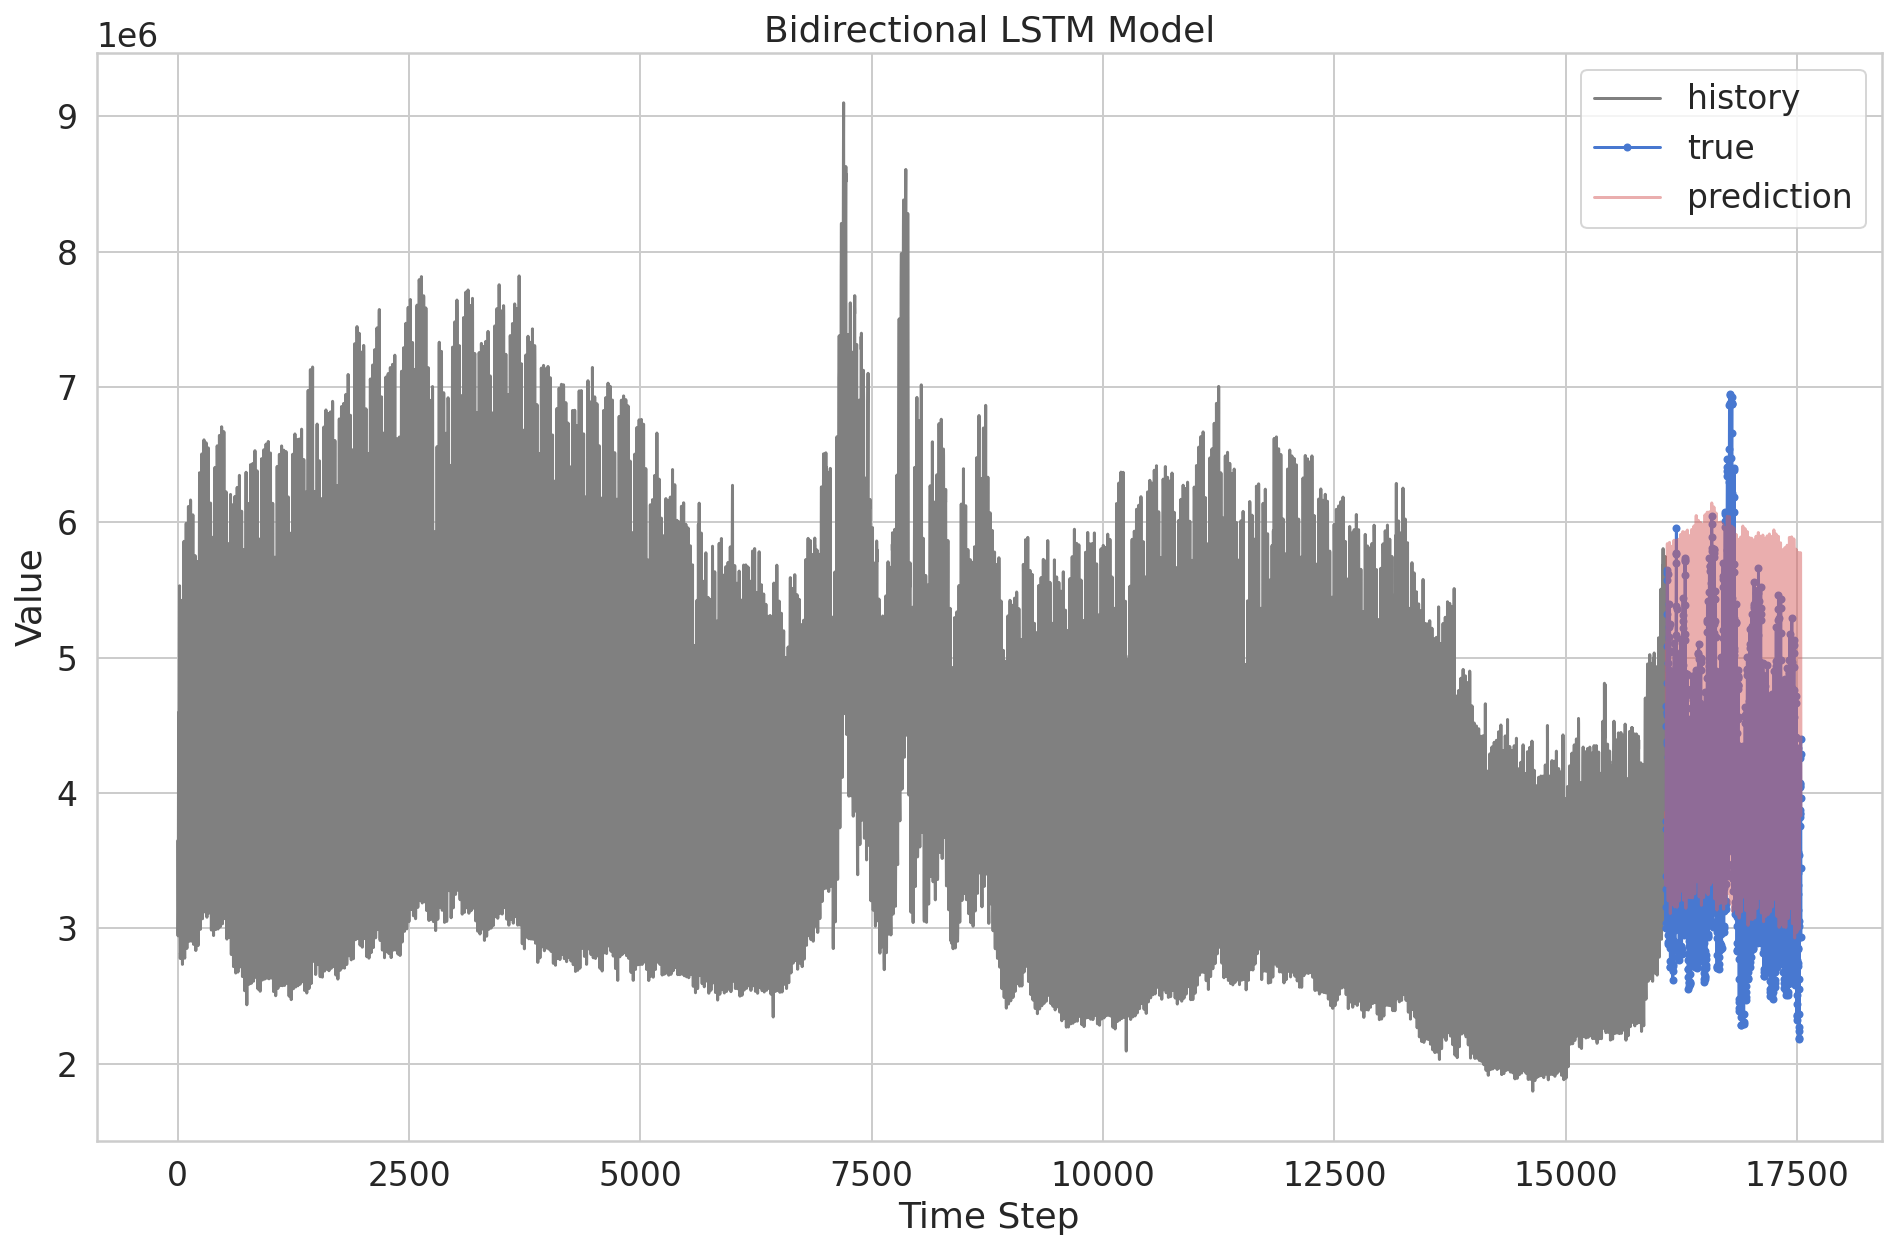

In [26]:
plt.plot(np.arange(0, len(train)+time_steps), sc.inverse_transform(df.VALORE_NORM[:len(train)+time_steps]), 'gray', label="history")
plt.plot(np.arange(len(train)+time_steps, len(train)+time_steps + len(y_test[-1])), y_test_true.reshape(-1,1), marker='.', label="true")
plt.plot(np.arange(len(train)+time_steps, len(train)+time_steps + len(y_test[-1])), y_pred_lstm2.reshape(-1,1), 'r', alpha=0.5, label="prediction")
plt.title("Bidirectional LSTM Model")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.savefig("lstm2_pred2.png")

plt.show()

<a name="cnn"></a>
## Training CNN

Compiliamo il modello con loss=MAE e Adam come optimizer. Successivamente fittiamo il modello con 50 epoche, su una batch size pari a 100 e un validation split pari al 20%.

In [27]:
model_cnn.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam(0.001))

In [28]:
history_cnn = model_cnn.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=100, 
    validation_split=0.2, 
    verbose=1, 
    shuffle=False
)

Epoch 1/50
94/94 [==============================] - 2s 11ms/step - loss: 0.7673 - val_loss: 0.4530
Epoch 2/50
94/94 [==============================] - 1s 9ms/step - loss: 0.5097 - val_loss: 0.4522
Epoch 3/50
94/94 [==============================] - 1s 9ms/step - loss: 0.5440 - val_loss: 0.4657
Epoch 4/50
94/94 [==============================] - 1s 9ms/step - loss: 0.5017 - val_loss: 0.4489
Epoch 5/50
94/94 [==============================] - 1s 9ms/step - loss: 0.5064 - val_loss: 0.4517
Epoch 6/50
94/94 [==============================] - 1s 9ms/step - loss: 0.5050 - val_loss: 0.4489
Epoch 7/50
94/94 [==============================] - 1s 9ms/step - loss: 0.4972 - val_loss: 0.4573
Epoch 8/50
94/94 [==============================] - 1s 9ms/step - loss: 0.4858 - val_loss: 0.4948
Epoch 9/50
94/94 [==============================] - 1s 9ms/step - loss: 0.5080 - val_loss: 0.4190
Epoch 10/50
94/94 [==============================] - 1s 8ms/step - loss: 0.4797 - val_loss: 0.4412
Epoch 11/50
94/94 

Plottiamo qui la loss su training e validation dataset.


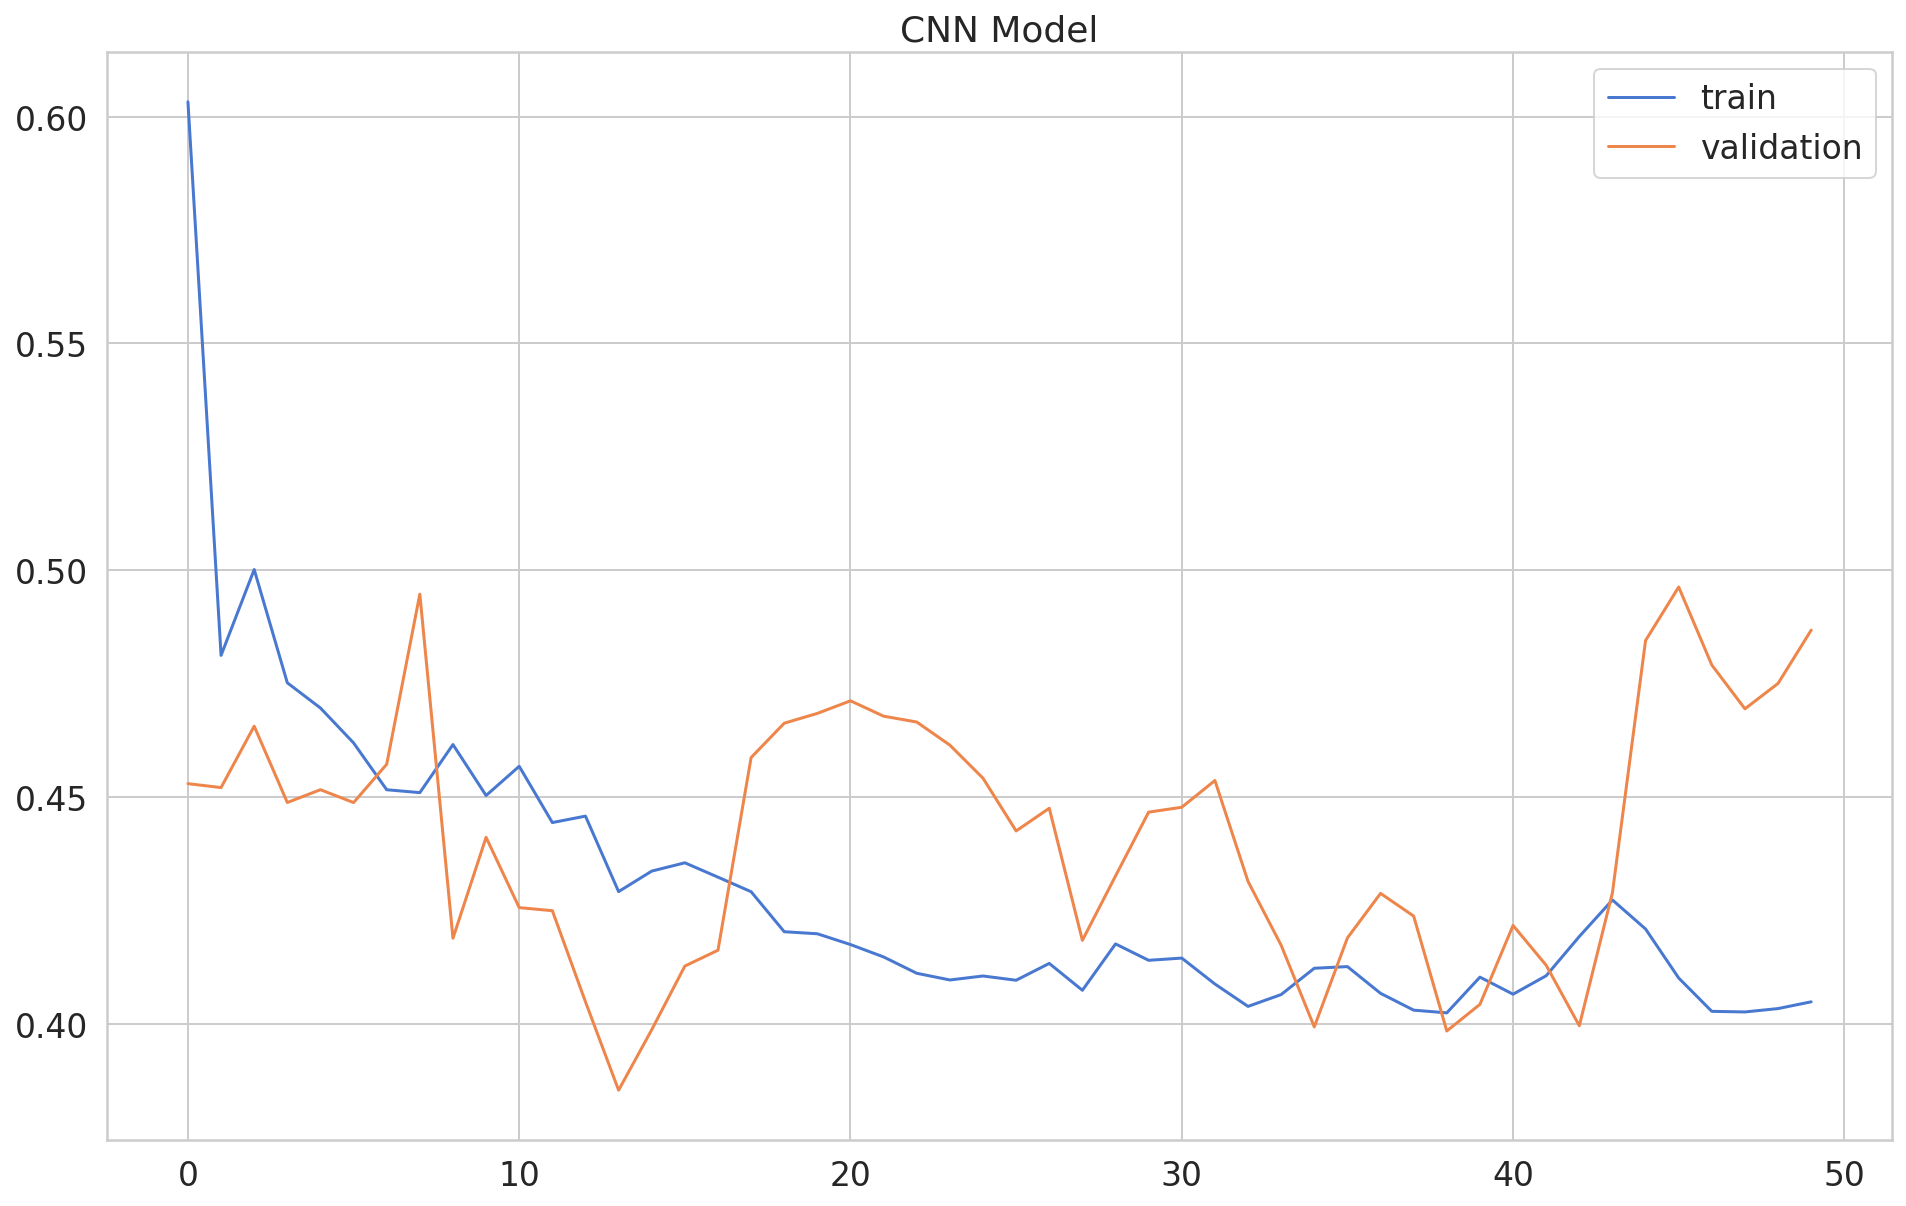

In [29]:
plt.plot(history_cnn.history['loss'], label='train')
plt.plot(history_cnn.history['val_loss'], label='validation')
plt.title("CNN Model")
plt.savefig("cnn_history.png")

plt.legend();

Ora effettuiamo le previsioni su X_test. Calcoliamo poi il mae sulle predizioni, trasformandolo con lo scaler che abbiamo definito ad inizio progetto, in modo da ottenere valori reali e non standardizzati.

In [30]:
y_pred_cnn = model_cnn.predict(X_test)

In [31]:
y_pred_cnn = sc.inverse_transform(y_pred_cnn)

mae_test_cnn = np.mean(abs(y_pred_cnn - y_test_true))
print(mae_test_cnn)

801812.3582531149


Plottiamo quindi le previsioni. Nel primo grafico vediamo soltanto predizioni e valori reali di test, mentre nel secondo vediamo predizioni e valori reali del test nel contesto della serie storica nella sua completezza.

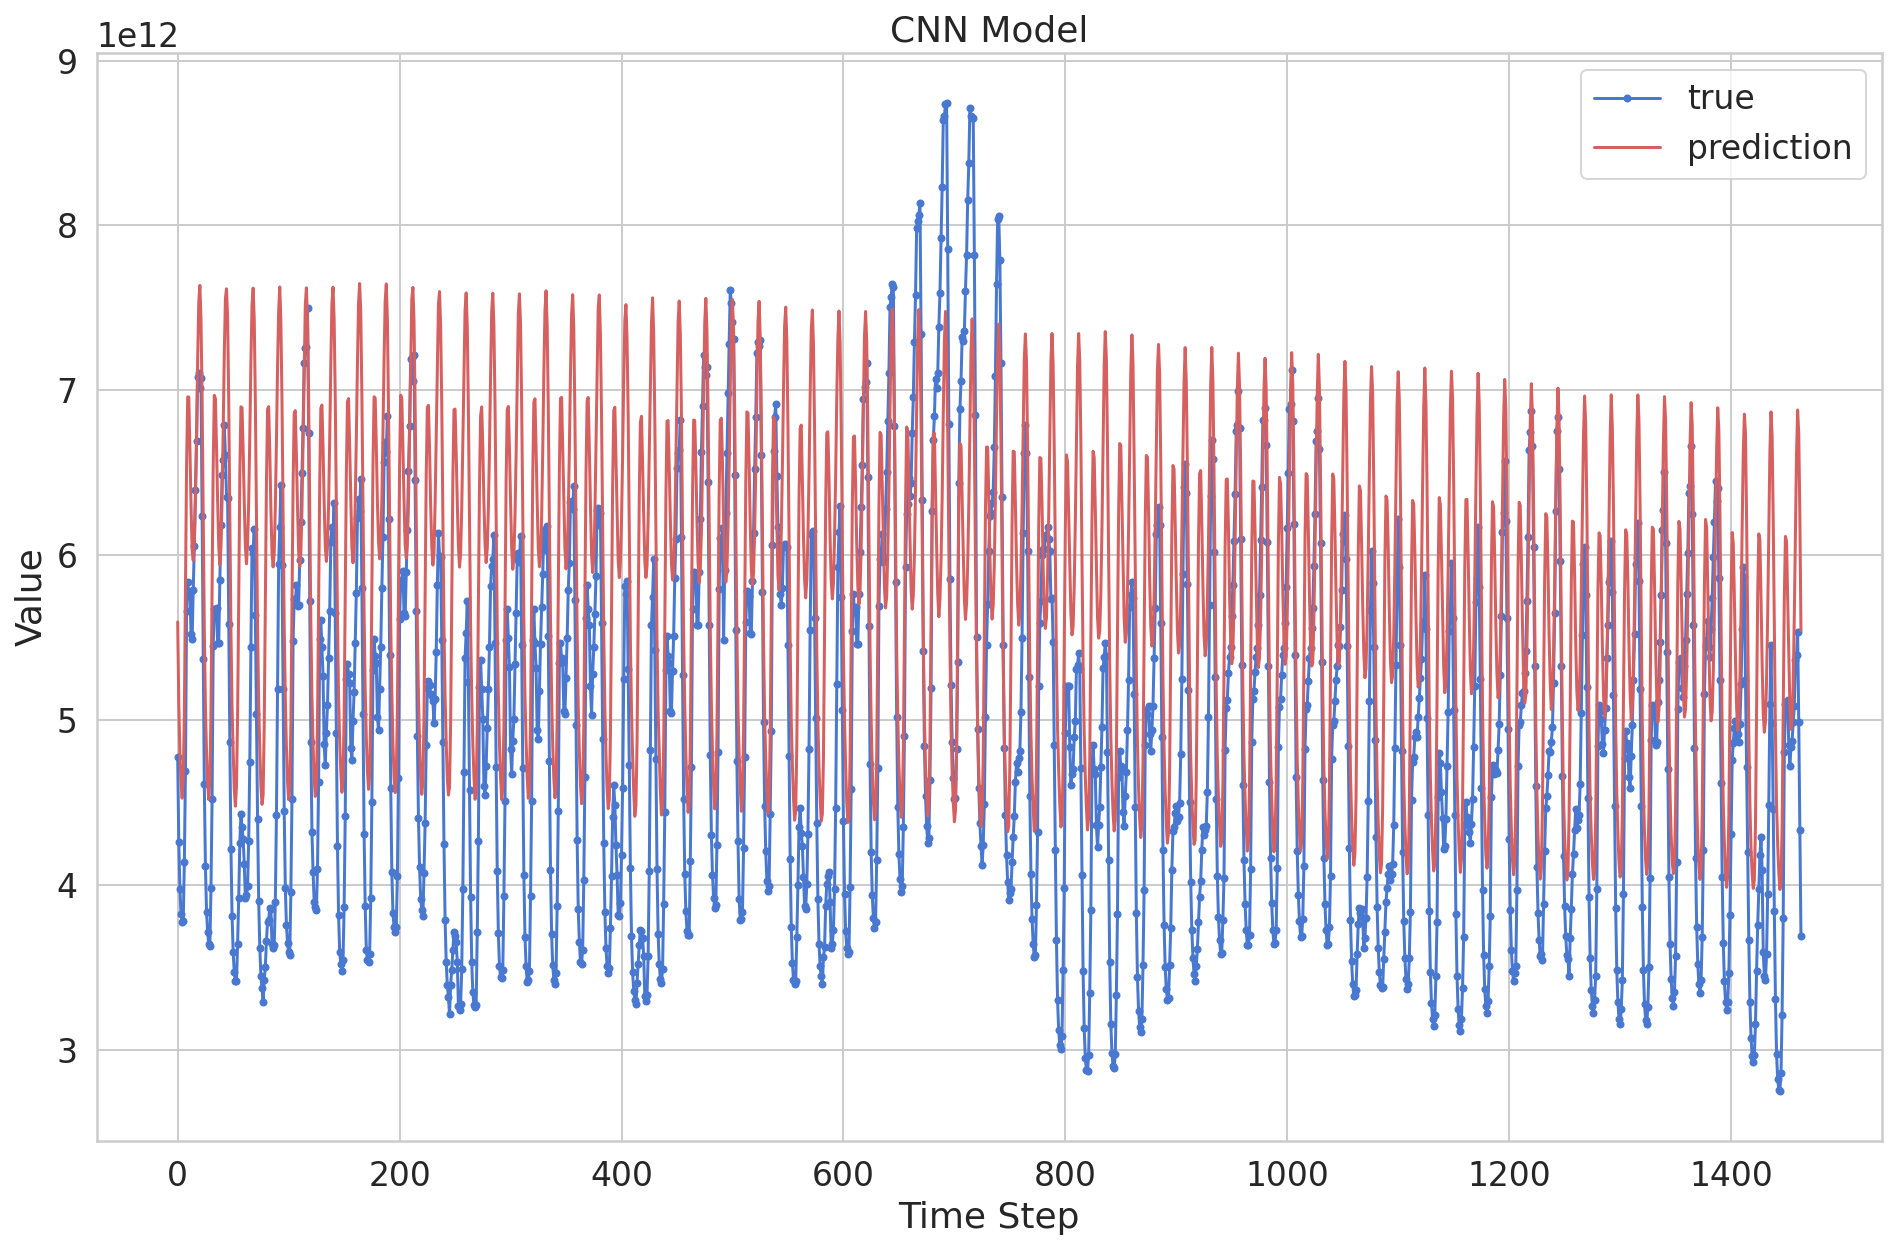

In [32]:
plt.plot(sc.inverse_transform(y_test_true[-1]), marker='.', label="true")
plt.plot(sc.inverse_transform(y_pred_cnn.reshape(-1,1)), 'r', label="prediction")
plt.title("CNN Model")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.savefig("cnn_pred1.png")

plt.show();

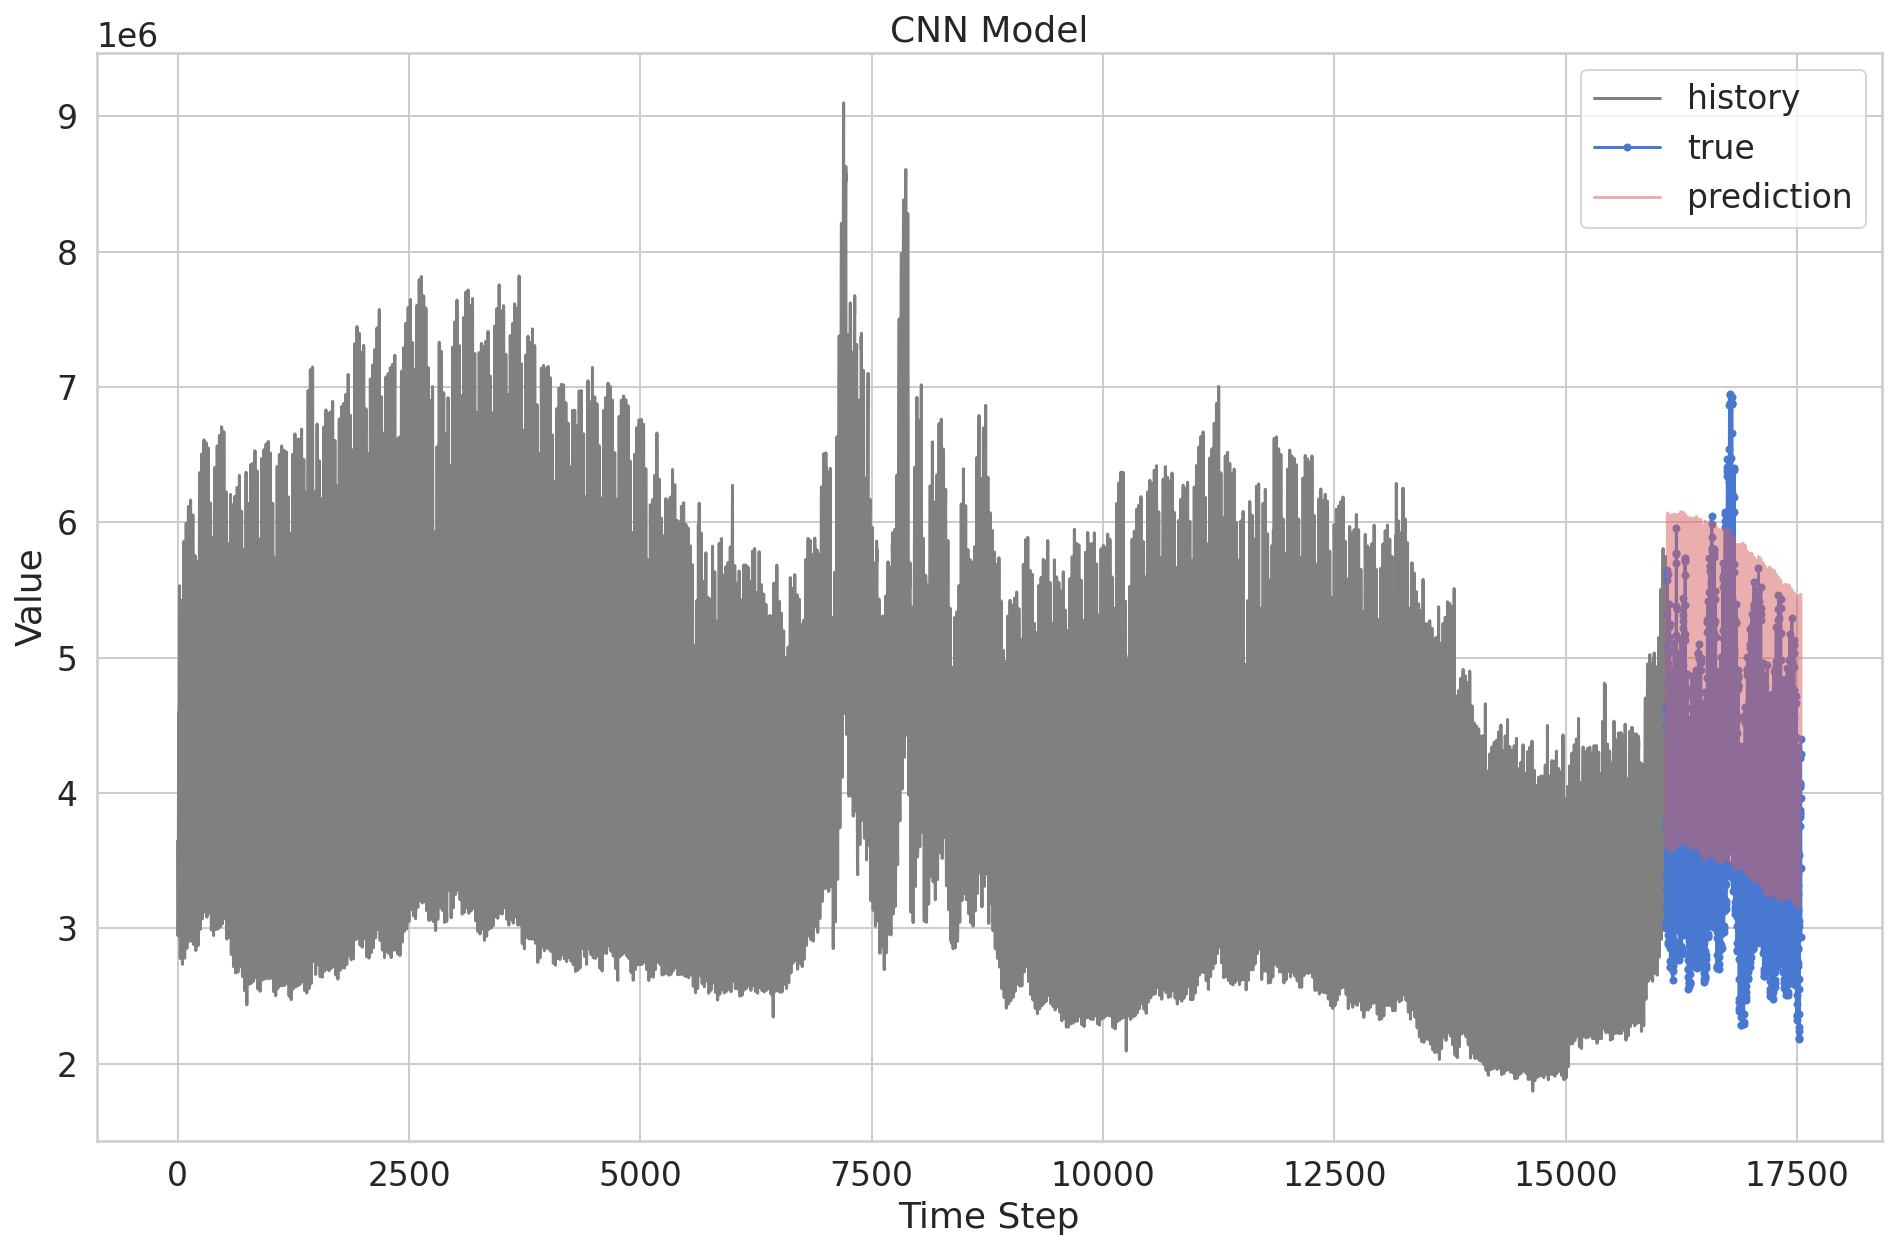

In [33]:
plt.plot(np.arange(0, len(train)+time_steps), sc.inverse_transform(df.VALORE_NORM[:len(train)+time_steps]), 'gray', label="history")
plt.plot(np.arange(len(train)+time_steps, len(train)+time_steps + len(y_test[-1])), y_test_true.reshape(-1,1), marker='.', label="true")
plt.plot(np.arange(len(train)+time_steps, len(train)+time_steps + len(y_test[-1])), y_pred_cnn.reshape(-1,1), 'r', alpha=0.5, label="prediction")
plt.title("CNN Model")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.savefig("cnn_pred2.png")

plt.show()

<a name="risultati"></a>
# Risultati
Come abbiamo potuto vedere, il modello migliore è stato il modello 1, con un MAE pari a 595674. Salviamo quindi le predizioni che prendono come input gli ultimi due mesi di dati nella apposita colonna del dataset creato nel file R, contente le previsioni ora per ora di tutti i diversi modelli provati (miglior ARIMA, miglior UCM, miglior modello Deep Learning)

In [34]:
X_for_prediction = df.tail(1464).values

In [35]:
X_for_prediction = np.expand_dims(X_for_prediction, axis=0)


In [36]:
final_predictions = model_lstm1.predict(X_for_prediction)

In [37]:
final_predictions_nonscaled = sc.inverse_transform(final_predictions)

In [38]:
risultati_time_series = pd.read_csv("SDMTSA_812166.csv")

In [49]:
risultati_time_series["ML"] = final_predictions_nonscaled[0]

In [50]:
risultati_time_series.to_csv('SDMTSA_812166.csv')

<a name="conclusioni"></a>
# Conclusioni

Dopo aver sviluppato tutti i modelli richiesti dal progetto (ARIMA, UCM, Modelli ML) possiamo trarre alcune conclusioni sugli stessi. Tra tutti i modelli e gli approcci che sono stati applicati, quello che senza dubbio si distingue è quello che sfrutta l'insieme dei 24 modelli ARIMA. In questo modo non solo si riduce il MAE sul Validation Set, ma si producono anche delle previsioni future che paiono più sensate e ragionevoli di quelle prodotte dagli altri approcci.

Grazie per l'attenzione.

Federico De Servi